In [23]:
class GameEngine:
    '''
    Provide utilities for this game
    '''
    
    def __init__(self, a_puzzle, a_solution):
        '''
        Engine constructor
        '''
            
        self.puzzle = a_puzzle
        self.solution = a_solution
        if a_solution:
            self.flat_solution = self.solution.reshape(self.puzzle.cells_count).tolist()
        else:
            self.flat_solution = None
        
        # init a board
        self.board = Board(a_puzzle)
        self.plotter = BoardPlotter(self.board)
        
        # init score
        self.errors = 0
        
        
    def show_board(self):
        ''' 
        Plot the board
        '''
        self.plotter.show()  
        
        
    def play(self, row, col, mark, apply=True):
        ''' 
        Play the game by sending the state of one cell
        Check whether an action is valid given a solution 
        If apply, update the board
        '''
        okay = self.solution[row, col] == mark.value   
        if not okay:
            self.errors += 1
           
        if apply:
            # apply the real state which is what games usually do
            true_mark = BoardMark(self.solution[row, col])
            self.board.mark(row, col, true_mark)
        return okay    
    
    
    def submit(self, states_list, apply=True):
        ''' 
        Submit the solution and give all the cells's state in one action
        Check whether the states given a the registered solution (assumes it has been given)
        '''
        # compute the difference between given board and known solution
        self.errors = sum([abs(p-e) for (p,e) in zip(states_list, self.flat_solution) if p>=0])
        if apply:
            self.board.fill_all(states_list)
        # board is okay when full and without errors
        return  states_list == self.flat_solution # must account for empty 
    
           
    def is_solved(self):
        '''
        Check whether the puzzle is solved
        '''
        
        done = True
        if done:
            done = self.board.count_empty() == 0
        if done:
            done = self.get_rows_blocks() == self.puzzle.norm_clues['rows']
        if done:
            done = self.get_cols_blocks() == self.puzzle.norm_clues['cols']
        return done
    
    
    def get_rows_blocks(self):
        '''
        Compute blocks for each rows
        '''
        
        rows = self.board.states
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
                   for line in rows]
        return blocks

    
    def get_cols_blocks(self):
        '''
        Compute blocks for each cols
        '''
        
        w = self.board.states.shape[0]
        h = self.board.states.shape[1]
        length = mul(w, h)
        cols = [ [self.board.states.reshape(length)[c+r*w]
                     for r in range(0, h)]
                 for c in range(0, w)]
        blocks = [ [len(list(g)) for k,g in groupby(line) if k==1]
                   for line in cols]
        return blocks    


In [9]:
from episode04 import clues2x2, clues5x5s, solution2x2, solution5x5s
from episode04 import Puzzle, BoardMark

import numpy as np

In [7]:
from episode04 import Board, BoardMark, BoardPlotter

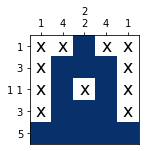

error_count:11


In [16]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)

for row in range(puzzle5x5s.height):
    for col in range(puzzle5x5s.width):
        game5x5s.play(row, col, BoardMark.BLACK)

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")
assert game5x5s.errors == 11 

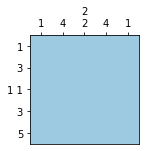

error_count:1


In [17]:
# create the game engine
puzzle5x5s = Puzzle(clues5x5s)
game5x5s = GameEngine(puzzle5x5s, solution5x5s)

okay = game5x5s.play(0, 0, BoardMark.BLACK, apply=False)
assert not okay 

game5x5s.show_board()
print(f"error_count:{game5x5s.errors}")
assert game5x5s.errors == 1 

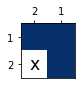

error_count:2


In [24]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)

okay = game2x2.submit([1, 1, 0, 1])
assert not okay 

game2x2.show_board()
print(f"error_count:{game2x2.errors}")
assert game2x2.errors == 2

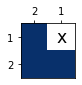

error_count:0


In [25]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)

okay = game2x2.submit([1, 0, 1, 1])
assert okay 

game2x2.show_board()
print(f"error_count:{game2x2.errors}")
assert game2x2.errors == 0

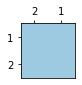

In [26]:
# create the game engine
puzzle2x2 = Puzzle(clues2x2)
game2x2 = GameEngine(puzzle2x2, solution2x2)

okay = game2x2.submit([1, 1, 0, 1], apply=False)
assert not okay 
game2x2.show_board()
assert game2x2.errors == 2 

# TODO sans solution ?

# Multiplotter

build from puzzle

consistent parameters (state ?)

autoregister states 

In [119]:
import numpy as np
from math import ceil

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

class BoardPlotter:
    '''
    Plot the board
    Require %matplotlib inline .
    '''
    
    cdict = {'red': [(0.0, 0.6196078431372549, 0.6196078431372549),
      (0.5, 1.0, 1.0),
      (1.0, 0.03137254901960784, 0.03137254901960784)],
     'green': [(0.0, 0.792156862745098, 0.792156862745098),
      (0.5, 1.0, 1.0),
      (1.0, 0.18823529411764706, 0.18823529411764706)],
     'blue': [(0.0, 0.8823529411764706, 0.8823529411764706),
      (0.5, 1.0, 1.0),
      (1.0, 0.4196078431372549, 0.4196078431372549)],
     'alpha': [(0.0, 1.0, 1.0),
      (0.5, 1.0, 1.0),
      (1.0, 1.0, 1.0)]}
    nono_cmap = LinearSegmentedColormap('nono', cdict)
    
    
    def __init__(self, a_board):
        '''
        Plotter contructor
        '''
        self.board = a_board
        self.clues = self.board.puzzle.given_clues
      
        def row_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else ' '.join(map(str,v))
        self.rows_labels = list(map(row_clue_to_label, self.clues['rows']))

        def col_clue_to_label(v):
            #print(v)
            return str(v) if not isinstance(v, list) else '\n'.join(map(str,v))
        self.cols_labels = list(map(col_clue_to_label, self.clues['cols']))
    
    
    def show(self):
        '''
        Show the plotter
        '''
        # WARNING :  the board is row col, while the fig is col row
        data = self.board.states
        w = self.board.width
        h = self.board.height
        nc = self.board.width * self.board.height
        
        # set some canvas
        # guess the figure size 
        # 1 fits 2 cells
        # 2 fits 5 cols
        figw = int(w/2) 
        figh = int(h/2) 
        fig, ax = plt.subplots(figsize=(figw,figh))
        # draw a heatmap
        # ensure value range is -1 to 1
        heatmap = ax.pcolor(data, cmap=self.nono_cmap, vmin=-1, vmax=1)

        # ensure square cells
        ax.set_aspect("equal")

        # put the major ticks at the middle of each cell
        ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
        ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

        # put labels on top
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        

        # set labels
        column_labels = self.clues['cols']
        row_labels = self.clues['rows']

        ax.set_xticklabels(self.cols_labels, minor=False)
        ax.set_yticklabels(self.rows_labels, minor=False)


        # annotate fillers
        # expect (col,row) is (1,0) for row=0 col=1
        fillers_coordinates = [(p%w + 0.5, int(p/w) + 0.5) 
                               for (p,v) in enumerate(data.reshape(nc)) 
                               if v==0]
        # place an X in the center of each coordinate
        for coord in fillers_coordinates:
            plt.text(coord[0], coord[1], 'x', 
                 verticalalignment='center',
                 horizontalalignment='center',
                 fontsize='xx-large')

        plt.show()
        
           
    def show_evolution(self, states_list):
        '''
        Show the plotter
        list of np arrays
        '''
        fig = plt.figure()
        #fig = plt.figure(figsize=(6,2))
        fig.subplots_adjust(left=5, right=15, top=12, bottom=5)
        i = 0
        for data in states_list:
            # WARNING :  the board is row col, while the fig is col row
            #data = self.board.states
            w = data.shape[1]
            h = data.shape[0]
            nc = w * h

            # set some canvas
            # guess the figure size 
            # 1 fits 2 cells
            # 2 fits 5 cols
            figw = int(w/2) 
            figh = int(h/2) 
            # fig, ax = plt.subplots(figsize=(figw,figh))
            plt.rcParams['figure.figsize'] = [figw,figh]
            i += 1
            ax = fig.add_subplot(ceil(len(states_list)/6), 6, i)
            # draw a heatmap
            # ensure value range is -1 to 1
            heatmap = ax.pcolor(data, cmap=self.nono_cmap, vmin=-1, vmax=1)

            # ensure square cells
            ax.set_aspect("equal")

            # put the major ticks at the middle of each cell
            ax.set_xticks(np.arange(data.shape[1]) + 0.5, minor=False)
            ax.set_yticks(np.arange(data.shape[0]) + 0.5, minor=False)

            # put labels on top
            ax.invert_yaxis()
            ax.xaxis.tick_top()


            # set labels
            column_labels = self.clues['cols']
            row_labels = self.clues['rows']

            ax.set_xticklabels(self.cols_labels, minor=False)
            ax.set_yticklabels(self.rows_labels, minor=False)


            # annotate fillers
            # expect (col,row) is (1,0) for row=0 col=1
            fillers_coordinates = [(p%w + 0.5, int(p/w) + 0.5) 
                                   for (p,v) in enumerate(data.reshape(nc)) 
                                   if v==0]
            # place an X in the center of each coordinate
            for coord in fillers_coordinates:
                plt.text(coord[0], coord[1], 'x', 
                     verticalalignment='center',
                     horizontalalignment='center',
                     fontsize='xx-large')

        plt.show()

In [121]:
puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(board2x2)

states1 = np.array([1,0,1,1]).reshape((2,2))
states2 = np.array([1,1,0,1]).reshape((2,2))

In [32]:
states2.shape

(2, 2)

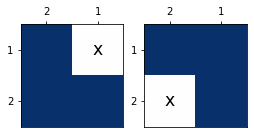

In [122]:
plotter2x2.show_evolution([states1, states2])

In [89]:
round(0.8)

1

In [123]:
import random

puzzle2x2 = Puzzle(clues2x2)
board2x2 = Board(puzzle2x2)
plotter2x2 = BoardPlotter(board2x2)

states_list = []
for i in range(20):
    states_float = np.random.rand(2, 2)
    f = np.vectorize(round)
    states = f(states_float) 
    states_list.append(states)
    
#states_list

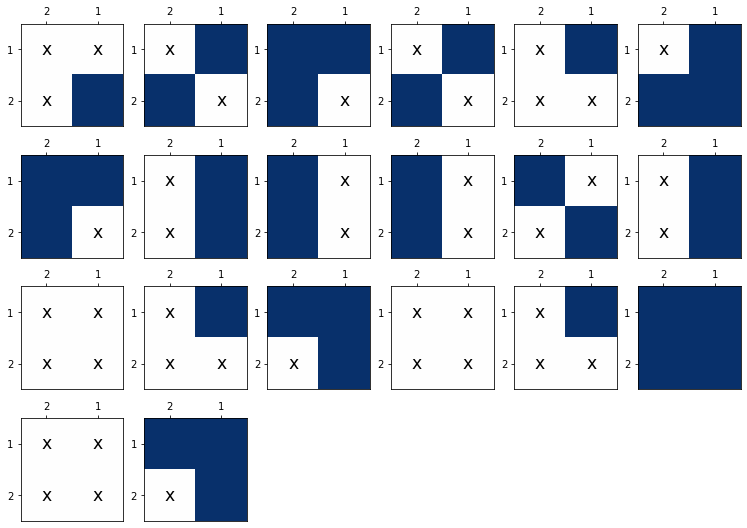

In [124]:
plotter2x2.show_evolution(states_list)